In [98]:
"""
Uczenie i analiza modelu klasyfikacji obrazów cifar za pomocą sieci CNN i wizualizacji GRAD-Cam.
Autor: Karol Szmajda
"""

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("TensorFlow:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
print("Wykryte GPU:", gpus)

if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"\nSzczegóły dla {gpu.name}:")
        for key, value in details.items():
            print(f"  {key}: {value}")
else:
    print("Nie wykryto żadnych GPU.")


TensorFlow: 2.18.0
Wykryte GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Szczegóły dla /physical_device:GPU:0:
  compute_capability: (8, 9)
  device_name: NVIDIA GeForce RTX 4070 Ti


In [95]:
# 1. Załadowanie i przygotowanie danych CIFAR-10
def load_and_preprocess_data():
    """ Ładuje i przygotowuje dane treningowe i testowe.
     
    Returns:
        tuple: Zawiera przetworzone dane treningowe i testowe oraz ich etykiety.
    """
    
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    # Normalizacja pikseli do zakresu [0,1]
    x_train = x_train.astype('float32') / 255.0
    x_test  = x_test.astype('float32') / 255.0
    
    # One-hot encoding etykiet
    y_train = to_categorical(y_train, 10)
    y_test  = to_categorical(y_test, 10)
    
    return x_train, y_train, x_test, y_test

# 2. Definicja modelu
def build_model(input_shape=(32, 32, 3), num_classes=10):
    """ Definiuje model CNN za pomocą Functional API.
    
    Args:
        input_shape (tuple, optional): Kształt wejścia.
        num_classes (int, optional): Liczba klas wyjściowych.
    
    Returns:
        tensorflow.keras.Model: Skompilowany model.
    """
    inputs = Input(shape=input_shape)

    # Blok konwolucyjny 1
    x = layers.Conv2D(32, (3,3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(32, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)
    
    # Blok konwolucyjny 2
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    # Blok konwolucyjny 3
    x = layers.Conv2D(128, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(128, (3,3), padding='same', name='conv_last')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('sigmoid')(x)
    
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)
    
    # Blok gęsty
    x = layers.Flatten()(x)
    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('leaky_relu')(x)

    x = layers.Dropout(0.25)(x)
    
    x = layers.Dense(32)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('leaky_relu')(x)
    
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)
    
    # Tworzenie modelu
    model = models.Model(inputs=inputs, outputs=outputs, name='cifar10_model')
    
    # Kompilacja modelu
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# 3. Trenowanie modelu
def train_model(model, x_train, y_train, batch_size=128, epochs=16, validation_split=0.1):
    """ Trenuje model na danych treningowych.

    Args:
        model (tensorflow.keras.Model): Skompilowany model do trenowania.
        x_train (numpy.ndarray): Dane treningowe.
        y_train (numpy.ndarray): Etykiety treningowe.
        batch_size (int, optional): Rozmiar batcha.
        epochs (int, optional): Liczba epok treningu.
        validation_split (float, optional): Część danych używana do walidacji.
    
    Returns:
        History: Obiekt historii treningu.
    """
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        validation_split=validation_split,
                        shuffle=True)
    return history

# 4. Ewaluacja modelu
def evaluate_model(model, x_test, y_test):
    """ Ewaluacja modelu na zbiorze testowym.
    
    Args:
        model (tensorflow.keras.Model): Wytrenowany model.
        x_test (numpy.ndarray): Dane testowe.
        y_test (numpy.ndarray): Etykiety testowe.
    
    Returns:
        tuple: Strata testowa i dokładność.
    """
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print("\nTest accuracy:", test_acc)
    return test_loss, test_acc

# 5. Implementacja Grad-CAM
def make_gradcam_heatmap(model, image, class_index, last_conv_layer_name, 
                         heatmap_size=(32, 32)):
    """ Tworzy mapę ciepła Grad-CAM dla danego obrazu i klasy.
    
    Args:
        model (tensorflow.keras.Model): Wytrenowany model.
        image (numpy.ndarray): Obraz wejściowy.
        class_index (int): Indeks klasy do wizualizacji.
        last_conv_layer_name (str): Nazwa ostatniej warstwy konwolucyjnej.
        heatmap_size (tuple, optional): Rozmiar mapy ciepła.
    
    Returns:
        numpy.ndarray: Znormalizowana mapa ciepła.
    """
    # Tworzenie modelu, który zwraca wyjścia ostatniej warstwy konwolucyjnej oraz predykcje
    grad_model = models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Obliczanie gradientów
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, class_index]
    
    # Obliczanie gradientów względem wybranej klasy
    grads = tape.gradient(loss, conv_outputs)
    
    # Uśrednianie gradientów na przestrzeni wymiarów (width, height)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    
    # Mnożenie każdej mapy cech przez odpowiadającą wagę
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    
    # Tworzenie mapy ciepła jako średnia po kanałach
    heatmap = np.mean(conv_outputs, axis=-1)
    
    # Normalizacja mapy ciepła
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    
    # Zmiana rozmiaru heatmap do rozmiaru oryginalnego obrazu
    heatmap = tf.image.resize(
        tf.expand_dims(heatmap, axis=-1),
        heatmap_size
    ).numpy().squeeze()
    
    return heatmap

def display_gradcam(image, heatmap, alpha=0.4):
    """ Nakłada mapę ciepła Grad-CAM na oryginalny obraz.

    Args:
        image (numpy.ndarray): Oryginalny obraz.
        heatmap (numpy.ndarray): Mapa ciepła Grad-CAM.
        alpha (float, optional): Współczynnik nakładania. Domyślnie 0.4.
    
    Returns:
        numpy.ndarray: Obraz z nałożoną mapą ciepła.
    """
    
    # Konwersja heatmap do kolorów
    heatmap_colored = plt.cm.jet(heatmap)[:, :, :3]
    
    # Nakładanie mapy ciepła na oryginalny obraz
    superimposed_img = alpha * image + (1 - alpha) * heatmap_colored
    superimposed_img = np.clip(superimposed_img, 0, 1)
    
    return superimposed_img

# 6. Wizualizacja Grad-CAM dla kilku obrazów testowych
def visualize_gradcam(model, x_test, y_test, class_names, num_images=5):
    """ Wizualizuje Grad-CAM dla wybranych obrazów testowych.

    Args:
        model (tensorflow.keras.Model): Wytrenowany model.
        x_test (numpy.ndarray): Dane testowe.
        y_test (numpy.ndarray): Etykiety testowe.
        class_names (list): Lista nazw klas.
        num_images (int, optional): Liczba obrazów do wizualizacji.
    """
    last_conv_layer_name = 'conv_last'  # Nazwa warstwy konwolucyjnej
    
    # Wybór losowych indeksów
    indices = np.random.choice(range(x_test.shape[0]), num_images, replace=False)
    
    plt.figure(figsize=(15, num_images * 3))
    
    for i, idx in enumerate(indices):
        image = x_test[idx]
        true_label = np.argmax(y_test[idx])
        
        # Przewidywanie
        preds = model.predict(np.expand_dims(image, axis=0))
        predicted_class = np.argmax(preds[0])
        
        # Tworzenie mapy ciepła
        heatmap = make_gradcam_heatmap(model, image, predicted_class, last_conv_layer_name)
        
        # Nakładanie mapy ciepła na obraz
        superimposed_img = display_gradcam(image, heatmap)
        
        # Wyświetlanie
        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(image)
        plt.title(f"Label: {class_names[true_label]}")
        plt.axis("off")
        
        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title("Mapa ciepła (Grad-CAM)")
        plt.axis("off")
        
        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(superimposed_img)
        plt.title(f"Predicted: {class_names[predicted_class]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [81]:
# Definicja nazw klas CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Ładujemy dane
x_train, y_train, x_test, y_test = load_and_preprocess_data()
print(f"Dane treningowe: {x_train.shape}, {y_train.shape}")
print(f"Dane testowe: {x_test.shape}, {y_test.shape}")

Dane treningowe: (50000, 32, 32, 3), (50000, 10)
Dane testowe: (10000, 32, 32, 3), (10000, 10)


In [82]:
# Zbuduj model
model = build_model()
model.summary()

Model: "cifar10_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_102         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_162 (Activation)     │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_103         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_163 (Activation)     │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_104         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_164 (Activation)     │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_105         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_165 (Activation)     │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_166 (Activation)     │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_last (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 422,730 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [83]:
# Trenowanie modelu
history = train_model(model, x_train, y_train, epochs=24)

# Ewaluacja modelu
evaluate_model(model, x_test, y_test)

Epoch 1/24
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3364 - loss: 1.8364 - val_accuracy: 0.2388 - val_loss: 2.1510
Epoch 2/24
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5806 - loss: 1.1673 - val_accuracy: 0.6408 - val_loss: 1.0021
Epoch 3/24
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6602 - loss: 0.9659 - val_accuracy: 0.6770 - val_loss: 0.9076
Epoch 4/24
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6960 - loss: 0.8584 - val_accuracy: 0.6818 - val_loss: 0.8947
Epoch 5/24
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7310 - loss: 0.7668 - val_accuracy: 0.7540 - val_loss: 0.7152
Epoch 6/24
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7500 - loss: 0.7085 - val_accuracy: 0.7670 - val_loss: 0.6796
Epoch 7/24
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7692 - loss: 0.6650 - val_accuracy: 0.7286 - val_loss: 0.8176
Epoch 8/24
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7838 - loss: 0.6190 - val_accuracy: 0

(0.5097149610519409, 0.8357999920845032)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


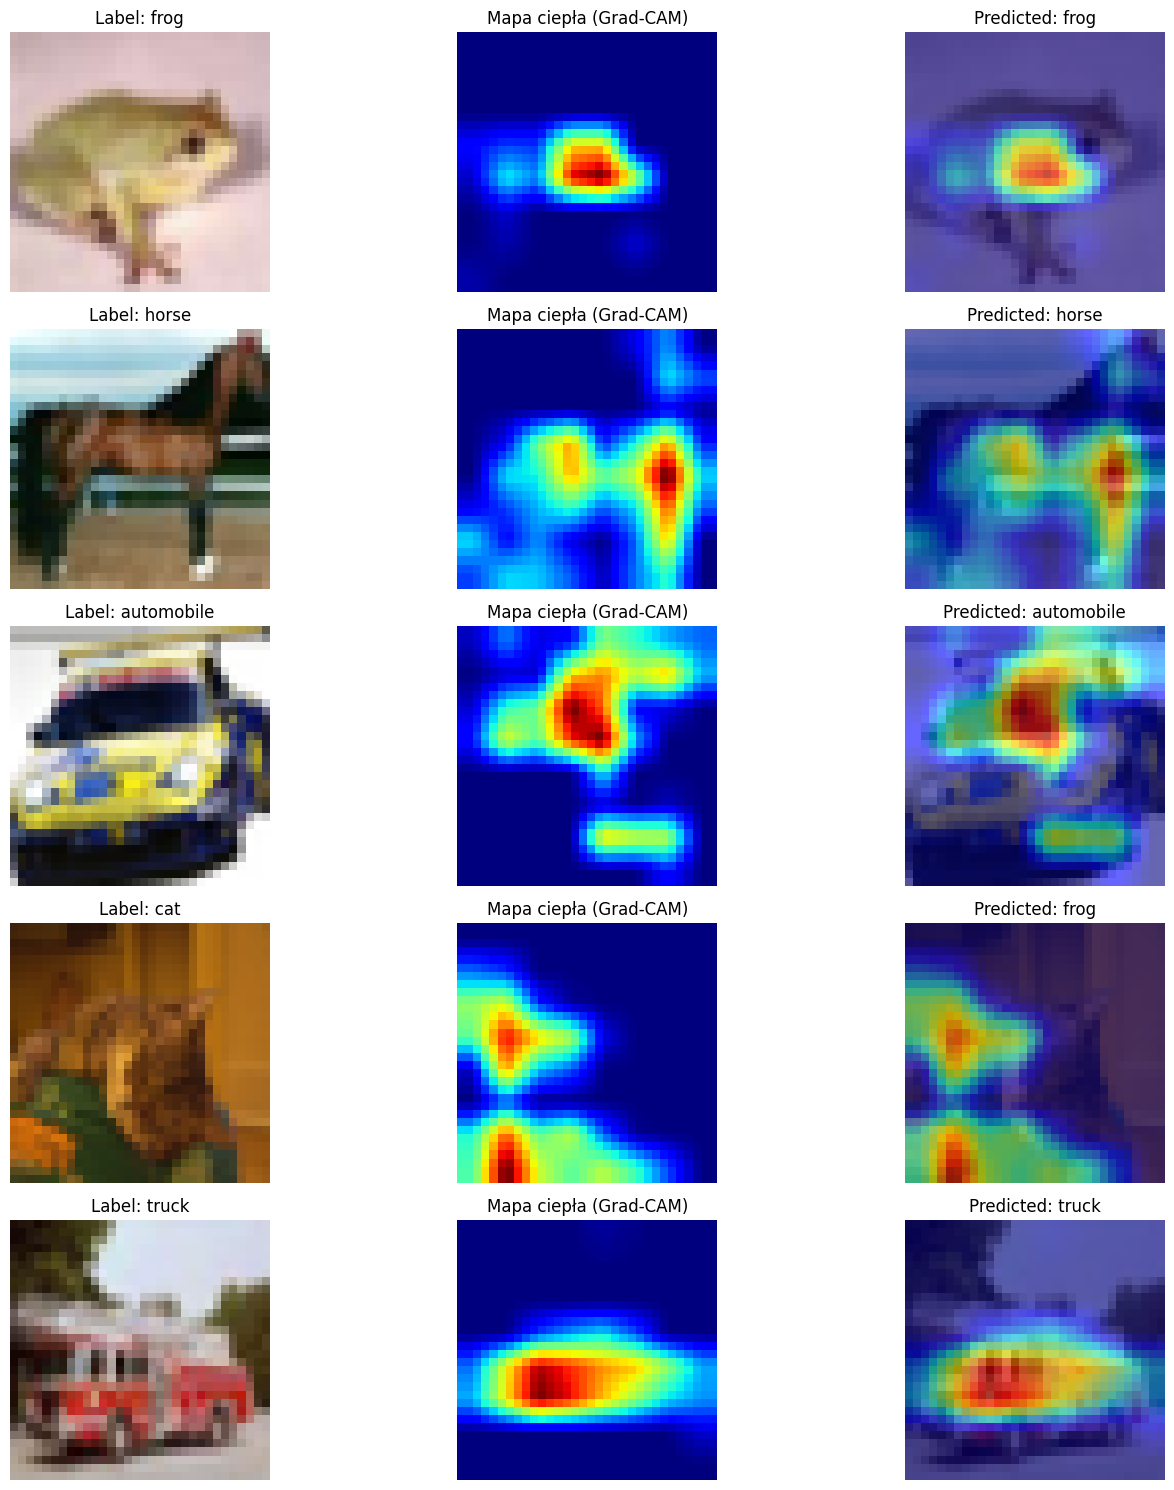

In [84]:
# Wizualizacja Grad-CAM
visualize_gradcam(model, x_test, y_test, class_names, num_images=5)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


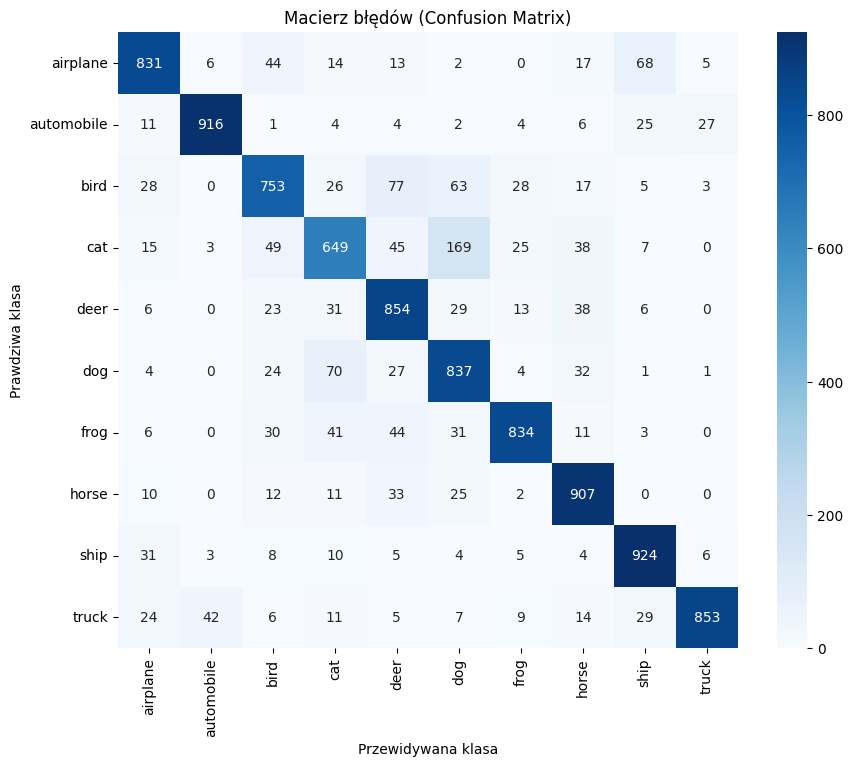

In [91]:
# Generowanie przewidywań na zbiorze testowym
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Prawdziwe klasy z etykiet one-hot
y_true = np.argmax(y_test, axis=1)

# Obliczanie macierzy błędów
cm = confusion_matrix(y_true, y_pred_classes)

# Tworzenie wykresu macierzy błędów
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Prawdziwa klasa')
plt.xlabel('Przewidywana klasa')
plt.title('Macierz błędów (Confusion Matrix)')
plt.show()

In [93]:
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Raport klasyfikacji:\n")
print(report)

Raport klasyfikacji:

              precision    recall  f1-score   support

    airplane       0.86      0.83      0.85      1000
  automobile       0.94      0.92      0.93      1000
        bird       0.79      0.75      0.77      1000
         cat       0.75      0.65      0.70      1000
        deer       0.77      0.85      0.81      1000
         dog       0.72      0.84      0.77      1000
        frog       0.90      0.83      0.87      1000
       horse       0.84      0.91      0.87      1000
        ship       0.87      0.92      0.89      1000
       truck       0.95      0.85      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

